<a href="https://colab.research.google.com/github/Tolevas/Credit-Card-Search-Tool/blob/main/CreditCard_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
#file_path = '/content/drive/My Drive/Johns Hopkins BARM/Consulting/Cleaned_creditcard_data.xlsx'
file_path = '/content/drive/My Drive/Johns Hopkins BARM/Consulting/merged_data (2).csv'

# Read the Excel file into a DataFrame
#data = pd.read_excel(file_path, engine='openpyxl')
data = pd.read_csv(file_path)

Mounted at /content/drive


In [2]:
# Display the first few rows of the DataFrame
print(data.columns.tolist())

['Institution Name', 'Product Name', 'Report Date', 'Availability of Credit Card Plan', 'State', 'State (Multiple)', 'Pertains to Specific Counties?', 'Requirements for Opening', 'Requirements for Opening Types', 'Geographic Restrictions', 'Professional Affiliation', 'Other', 'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?', 'Purchase APR Vary by Balance', 'Purchase APR Balance Tier 1', 'Purchase APR Tier 1 From Balance', 'Purchase APR Tier 1 to Balance', 'Purchase APR Balance Tier 2', 'Purchase APR Tier 2 From Balance', 'Purchase APR Tier 2 To Balance', 'Purchase APR Balance Tier 3', 'Purchase APR Tier 3 From Balance', 'Purchase APR Tier 3 To Balance', 'Purchase APR Balance Tier 4', 'Purchase APR Tier 4 From Balance', 'Purchase APR Tier 4 To Balance', 'Purchase APR Index', 'Variable Rate Index', 'Index', 'Purchase APR Vary by Credit Tier', 'Purchase APR poor', 'Purchase APR good', 'Purchase APR great', 'Purchase APR min', 'Purchase APR median', 'Purchase APR max', 'Int

In [3]:
#convert 9.98 to 0.098
data['Purchase APR min']= data['Purchase APR min'].replace(9.98, 0.098)
data = data[data['Intro APR max'] != 0.3024]

In [4]:
# create binary columns for credit score ranges for later analysis.
#Will allow customers to speficy their credit range and search cards available to them
# Define the possible credit score ranges
credit_score_ranges = [
    'No credit score',
    'Credit score 619 or less',
    'Credit scores from 620 to 719',
    'Credit score of 720 or greater'
]

#No credit score; Credit scores from 620 to 719; Credit score of 720 or greater
# Initialize binary columns for each credit score range
for score_range in credit_score_ranges:
    data[score_range] = 0

# Populate the binary columns
for index, row in data.iterrows():
    targeted_credit_tiers = row['Targeted Credit Tiers']
    for score_range in credit_score_ranges:
        if score_range in targeted_credit_tiers:
            data.at[index, score_range] = 1

# Save the updated dataset
updated_file_path = '/content/drive/My Drive/Johns Hopkins BARM/Consulting/Cleaned_creditcard_data.xlsx'
data.to_excel(updated_file_path, index=False)

In [5]:
import numpy as np
data.loc[data['Product Name'] == 'Hawaiian World Elite Mastercard', 'Advance APR median'] = \
    data.loc[data['Product Name'] == 'Hawaiian World Elite Mastercard', 'Advance APR median'].replace(0, np.nan)


In [6]:
print(data[['No credit score',
    'Credit score 619 or less',
    'Credit scores from 620 to 719',
    'Credit score of 720 or greater']])

     No credit score  Credit score 619 or less  Credit scores from 620 to 719  \
0                  1                         0                              1   
1                  0                         0                              1   
2                  0                         1                              1   
3                  1                         1                              1   
4                  1                         1                              1   
..               ...                       ...                            ...   
643                0                         1                              1   
644                0                         0                              1   
645                1                         1                              1   
646                0                         0                              1   
647                0                         0                              0   

     Credit score of 720 or

# Card Features data Cleaning and Engineering

In [7]:
# look at all unique strings in the Card Features column
unique_features = set()
for features in data['Card Features'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Chip card
Contactless Payments
Fee-free foreign transactions
Mobile wallet provisioning (for example, Apple Pay)
Other


In [8]:
data['Card Features'].fillna('No_features', inplace=True)

In [9]:
#This will replace all 'Other' strings in the Card Features columns with 'Other_features' beucause we will turn this into its own column
#later when we convert it to dummies.  Other columns that will be converted to duimmy columns also have 'Other' categories so we need to
#replace them with 'Other_...' that seperates them from one another
def replace_other_features(row):
    if pd.notna(row):
        features = row.split('; ')
        features = ['Other_features' if feature == 'Other' else feature for feature in features]
        return '; '.join(features)
    return row

# Apply the function to the 'Card Features' column
data['Card Features'] = data['Card Features'].apply(replace_other_features)

# Save the updated dataset
updated_file_path = 'path_to_save_updated_creditcard_data.xlsx'
data.to_excel(updated_file_path, index=False)

In [10]:
#check that the code above accomplished the intended task
unique_features = set()
for features in data['Card Features'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Chip card
Contactless Payments
Fee-free foreign transactions
Mobile wallet provisioning (for example, Apple Pay)
No_features
Other_features


In [11]:
# This code seperates the Card Features column into 5 columns with binary outputs for each of the card features listed below. this will amke it easier to analyze
# i have chosen to leave the Other Card Features column out of our analysis as features vary greatly and it would add too many columns to our dataset
# the entity collecting TCCP data should make a more structured method for card providers to imput features into the dataset.
# a true production tool would include these OTHER features in some form
# Define the possible card features
card_features = [
    'Chip card',
    'Contactless Payments',
    'Fee-free foreign transactions',
    'Mobile wallet provisioning (for example, Apple Pay)',
    'Other_features',
    'No_features'
]

# Initialize binary columns for each card feature
for feature in card_features:
    data[feature] = 0

# Populate the binary columns
for index, row in data.iterrows():
    card_features_list = row['Card Features']
    if pd.notna(card_features_list):
        for feature in card_features:
            if feature in card_features_list:
                data.at[index, feature] = 1

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

print(data[['Chip card',
    'Contactless Payments',
    'Fee-free foreign transactions',
    'Mobile wallet provisioning (for example, Apple Pay)',
    'Other_features',
    'No_features']])

     Chip card  Contactless Payments  Fee-free foreign transactions  \
0            1                     1                              1   
1            1                     1                              0   
2            1                     1                              1   
3            1                     1                              1   
4            1                     1                              1   
..         ...                   ...                            ...   
643          1                     1                              0   
644          1                     0                              0   
645          1                     1                              1   
646          1                     1                              1   
647          1                     1                              1   

     Mobile wallet provisioning (for example, Apple Pay)  Other_features  \
0                                                    0                 

# Services  Column Cleaning/Engineering#

In [12]:
#lets look at all the possible card "Services"
unique_features = set()
for features in data['Services'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Access to Free Credit Scores
Automobile rental insurance
Credit card registration
Debt cancellation coverage
Discounts on purchases of goods and services (non travel related)
Extension on manufacturer’s warranty
Other


In [13]:
data['Services'].fillna('No_Services', inplace=True)

In [14]:
#This will replace all 'Other' strings in the Services columns with 'Other_features' beucause we will turn this into its own column
#later when we convert it to dummies.  Other columns that will be converted to duimmy columns also have 'Other' categories so we need to
#replace them with 'Other_...' that seperates them from one another
def replace_other_features(row):
    if pd.notna(row):
        features = row.split('; ')
        features = ['Other_services' if feature == 'Other' else feature for feature in features]
        return '; '.join(features)
    return row

# Apply the function to the 'Card Features' column
data['Services'] = data['Services'].apply(replace_other_features)

# Save the updated dataset
updated_file_path = 'path_to_save_updated_creditcard_data.xlsx'
data.to_excel(updated_file_path, index=False)

In [15]:
#lets look at all the possible card "Services" after the change to make sure it worked
unique_features = set()
for features in data['Services'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Access to Free Credit Scores
Automobile rental insurance
Credit card registration
Debt cancellation coverage
Discounts on purchases of goods and services (non travel related)
Extension on manufacturer’s warranty
No_Services
Other_services


In [16]:
# This code chunk combines the state, multiple state columns into one column containing all states where that card is available (
    #maybe should get rid of 'region' column also? prob not because people want to know where their card is available outside of their home state

# List of all state abbreviations
all_states = [
    'AA', 'AE', 'AK', 'AL', 'AP', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'FM',
    'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MH', 'MI',
    'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
    'OR', 'PA', 'PR', 'PW', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'
]

# Function to combine state columns
def combine_states(row):
    states = set()
    if pd.notna(row['State']):
        states.update(row['State'].split(';'))
    if pd.notna(row['State (Multiple)']):
        states.update(row['State (Multiple)'].split(';'))
    if not states:
        states.update(all_states)
    return '; '.join(sorted(states))

# Combine 'State' and 'State (Multiple)' into a new column 'Available States'
data['Available States'] = data.apply(combine_states, axis=1)

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

data.drop(columns=['State', 'State (Multiple)', 'Pertains to Specific Counties?'], inplace=True)
print(data['Available States'])

0      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
1                                                 WA; OR
2      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
3      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
4      AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
                             ...                        
643    AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
644                                                   WA
645    AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
646    AA; AE; AK; AL; AP; AR; AS; AZ; CA; CO; CT; DC...
647                                          UT;  WY; ID
Name: Available States, Length: 647, dtype: object


In [17]:
# This splits the Services column up into individual columns for each service and gives a binary 0 or 1 for if that row has the service or not
# OTHER services and columns are once again ignored as they very too much between card providers to be analyzed as a group
# Define the possible services
services = [
    'Access to Free Credit Scores',
    'Automobile rental insurance',
    'Credit card registration',
    'Debt cancellation coverage',
    'Discounts on purchases of goods and services (non travel related)',
    'Extension on manufacturer’s warranty',
    'Other_services',
    'No_Services'
]

# Initialize binary columns for each service
for service in services:
    data[service] = 0

# Populate the binary columns
for index, row in data.iterrows():
    services_list = row['Services']
    if pd.notna(services_list):
        for service in services:
            if service in services_list:
                data.at[index, service] = 1

data.to_excel(updated_file_path, index=False)

# check that it worked
print(data[['Access to Free Credit Scores',
    'Automobile rental insurance',
    'Credit card registration',
    'Debt cancellation coverage',
    'Discounts on purchases of goods and services (non travel related)',
    'Extension on manufacturer’s warranty',
    'Other_services',
    'No_Services']])

     Access to Free Credit Scores  Automobile rental insurance  \
0                               0                            0   
1                               0                            0   
2                               1                            0   
3                               1                            0   
4                               1                            0   
..                            ...                          ...   
643                             1                            0   
644                             0                            1   
645                             0                            0   
646                             0                            0   
647                             0                            1   

     Credit card registration  Debt cancellation coverage  \
0                           0                           0   
1                           1                           0   
2                       

# Rewards column data Cleaning/Engineering #

In [18]:
#lets look at all the possible card "Rewards"
unique_features = set()
for features in data['Rewards'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Cashback rewards
Other rewards
Travel-related rewards


In [19]:
data['Rewards'].fillna('No_rewards', inplace=True)

In [20]:
#This splits the Services column up into individual columns for each service and gives a binary 0 or 1 for if that row has the service or not
# OTHER rewards and columns are once again ignored as they very too much between card providers to be analyzed as a group
# Define the possible services
rewards = [
    'Cashback rewards',
    'Other rewards',
    'Travel-related rewards',
    'No_rewards'
]

# Initialize binary columns for each service
for reward in rewards:
    data[reward] = 0

# Populate the binary columns
for index, row in data.iterrows():
    rewards_list = row['Rewards']
    if pd.notna(rewards_list):
        for reward in rewards:
            if reward in rewards_list:
                data.at[index, reward] = 1

data.to_excel(updated_file_path, index=False)

print(data[['Cashback rewards',
    'Other rewards',
    'Travel-related rewards',
    'No_rewards']])

     Cashback rewards  Other rewards  Travel-related rewards  No_rewards
0                   0              0                       0           1
1                   1              0                       0           0
2                   0              0                       0           1
3                   0              0                       0           1
4                   0              0                       0           1
..                ...            ...                     ...         ...
643                 1              0                       0           0
644                 0              1                       1           0
645                 0              0                       0           1
646                 1              0                       1           0
647                 1              0                       0           0

[647 rows x 4 columns]


# Opening Requirements #

In [21]:
#lets look at all the possible card 'Requirements for Opening Types'
unique_features = set()
for features in data['Requirements for Opening Types'].dropna():
    for feature in features.split(';'):
        unique_features.add(feature.strip())

# Convert the set to a sorted list
unique_features = sorted(unique_features)

# Print all unique features
for feature in unique_features:
    print(feature)

Geographic Restrictions Beyond Place of Residence
Other. Please Describe:
Professional Affiliation


In [22]:
data['Requirements for Opening Types'].fillna('No_opening_requirements', inplace=True)

In [23]:
#this splits the opening requirements column up into individual columns for each service and gives a binary 0 or 1 for if that row has the service or not
# there are many other specific requirements that would need to be encoded in a formal tool!!!!!
# Define the possible opening requirement types
opening_requirements = [
    'Geographic Restrictions Beyond Place of Residence',
    'Other. Please Describe:',
    'Professional Affiliation',
    'No_opening_requirements'
]

# Initialize binary columns for each opening requirement type
for requirement in opening_requirements:
    data[requirement] = 0

# Populate the binary columns
for index, row in data.iterrows():
    requirements_list = row['Requirements for Opening Types']
    if pd.notna(requirements_list):
        for requirement in opening_requirements:
            if requirement in requirements_list:
                data.at[index, requirement] = 1

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

# Print the updated DataFrame to verify the changes
print(data[['Geographic Restrictions Beyond Place of Residence',
            'Other. Please Describe:',
            'Professional Affiliation',
            'No_opening_requirements']].head())

   Geographic Restrictions Beyond Place of Residence  Other. Please Describe:  \
0                                                  0                        0   
1                                                  0                        1   
2                                                  0                        0   
3                                                  0                        0   
4                                                  0                        0   

   Professional Affiliation  No_opening_requirements  
0                         0                        1  
1                         0                        0  
2                         0                        1  
3                         0                        1  
4                         0                        1  


# Fee columns data cleaning

In [24]:
#impute Periodic Fee Type column with 'none' string in place of NANs
 # Impute NaN values in the 'Periodic Fee Type' column with 'None'
data['Periodic Fee Type'].fillna('None', inplace=True)

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

# Print the updated 'Periodic Fee Type' column to verify the changes
print(data['Periodic Fee Type'].head())


0    Annual
1      None
2      None
3      None
4      None
Name: Periodic Fee Type, dtype: object


In [25]:
#Impute nans in 'Balance Transfer Fee (%)' and 'Minimum Balance Transfer Fee Amount' columns with 0 int
data['Minimum Balance Transfer Fee Amount'].fillna(0, inplace=True)
data['Balance Transfer Fee (%)'].fillna(0, inplace=True)

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

In [26]:
# List of columns to fill NaNs with 0
columns_to_fill = [
    'Cash Advance Fee ($)',
    'Cash Advance Fee (%)',
    'Minimum Cash Advance Fee Amount',
    'Foreign Transaction Fee (%)',
    'Late Fee ($)',
    'Late Fee Six Month Billing Cycle',
    'Over Limit Fee ($)',
    'Annual Fee',
    'Monthly Fee',
    'Weekly Fee',
    'Balance Transfer Fee ($)',
    'Balance Transfer Fee (%)',
    'Cash Advance Fee ($)',
    'Cash Advance Fee (%)',
    'Minimum Cash Advance Fee Amount',
    'Foreign Transaction Fee (%)',
    'Late Fee ($)',
    'Minimum Balance Transfer Fee Amount',
]

# Impute NaN values in the specified columns with 0
for column in columns_to_fill:
    data[column].fillna(0, inplace=True)

# Save the updated dataset
data.to_excel(updated_file_path, index=False)

print(data[columns_to_fill].head())

   Cash Advance Fee ($)  Cash Advance Fee (%)  \
0                   3.0                  0.03   
1                   0.0                  0.00   
2                   0.0                  0.05   
3                   0.0                  0.05   
4                   0.0                  0.05   

   Minimum Cash Advance Fee Amount  Foreign Transaction Fee (%)  Late Fee ($)  \
0                              3.0                         0.00          30.0   
1                              0.0                         0.01          35.0   
2                             10.0                         0.00          29.0   
3                             10.0                         0.00          29.0   
4                             10.0                         0.00          29.0   

   Late Fee Six Month Billing Cycle  Over Limit Fee ($)  Annual Fee  \
0                              41.0                 0.0        25.0   
1                               0.0                 0.0         0.0   
2    

In [27]:
# Create the new column 'Cumulative Yearly Fee'
data['Cumulative Yearly Fee'] = 0

# Define a function to calculate the cumulative yearly fee
def calculate_cumulative_yearly_fee(row):
    annual_fee = row['Annual Fee'] if pd.notna(row['Annual Fee']) else 0
    monthly_fee = (row['Monthly Fee'] * 12) if pd.notna(row['Monthly Fee']) else 0
    weekly_fee = (row['Weekly Fee'] * 52) if pd.notna(row['Weekly Fee']) else 0
    return annual_fee + monthly_fee + weekly_fee

# Apply the function to each row in the DataFrame
data['Cumulative Yearly Fee'] = data.apply(calculate_cumulative_yearly_fee, axis=1)

# Display the updated DataFrame
print(data[['Annual Fee', 'Monthly Fee', 'Weekly Fee', 'Cumulative Yearly Fee']])

     Annual Fee  Monthly Fee  Weekly Fee  Cumulative Yearly Fee
0          25.0          0.0         0.0                   25.0
1           0.0          0.0         0.0                    0.0
2           0.0          0.0         0.0                    0.0
3           0.0          0.0         0.0                    0.0
4           0.0          0.0         0.0                    0.0
..          ...          ...         ...                    ...
643         0.0          0.0         0.0                    0.0
644         0.0          0.0         0.0                    0.0
645         0.0          0.0         0.0                    0.0
646         0.0          0.0         0.0                    0.0
647         0.0          0.0         0.0                    0.0

[647 rows x 4 columns]


In [28]:
# Print the columns for the row with "Fortiva MasterCard, Aspire MasterCard" in the Product Name column
specific_row = data[data['Product Name'] == "Fortiva MasterCard, Aspire MasterCard"]
print(specific_row[['Product Name', 'Annual Fee', 'Monthly Fee', 'Weekly Fee', 'Cumulative Yearly Fee']])


                             Product Name  Annual Fee  Monthly Fee  \
67  Fortiva MasterCard, Aspire MasterCard       175.0         12.5   

    Weekly Fee  Cumulative Yearly Fee  
67         0.0                  325.0  


In [29]:
valid_rewards = data['Purchase Transaction Fees'].unique()
print(valid_rewards)

data['Purchase Transaction Fees'].value_counts()

['No']


Purchase Transaction Fees
No    647
Name: count, dtype: int64

In [30]:
# Define the columns to drop (they have no data so are just taking up space)
columns_to_drop = [
    'Purchase Transaction Fees',
    'Purchase Transaction Fee Type',
    'Purchase Transaction Fee ($)',
    'Purchase Transaction Fee (%)',
    'Minimum Purchase Transaction Fee Amount',
    'Purchase Transaction Fee Calculation'
]

# Drop the specified columns
data.drop(columns=columns_to_drop, inplace=True)

In [31]:
# Define the columns to drop (they have no data so are just taking up space)
columns_to_drop = [
    'Purchase APR Balance Tier 1',
    'Purchase APR Tier 1 From Balance',
    'Purchase APR Tier 1 to Balance',
    'Purchase APR Balance Tier 2',
    'Purchase APR Tier 2 From Balance',
    'Purchase APR Tier 2 To Balance',
    'Purchase APR Balance Tier 3',
    'Purchase APR Tier 3 From Balance',
    'Purchase APR Tier 3 To Balance',
    'Purchase APR Balance Tier 4',
    'Purchase APR Tier 4 From Balance',
    'Purchase APR Tier 4 To Balance'
]

# Drop the specified columns
data.drop(columns=columns_to_drop, inplace=True)

In [32]:
def combine_balance_transfer_fees(row):
    parts = []

    if pd.notna(row['Balance Transfer Fee ($)']):
        parts.append(f"Balance Transfer fee: {row['Balance Transfer Fee ($)']}$")
    if pd.notna(row['Balance Transfer Fee (%)']):
        parts.append(f"Percentage Balance Transfer fee: {row['Balance Transfer Fee (%)']}%")
    if pd.notna(row['Minimum Balance Transfer Fee Amount']):
        parts.append(f"Minimum Balance Transfer fee: {row['Minimum Balance Transfer Fee Amount']}$")

    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Balance Transfer Fees Cumulative'] = data.apply(combine_balance_transfer_fees, axis=1)

# Display the updated DataFrame with the new column
print(data['Balance Transfer Fees Cumulative'])

0      Balance Transfer fee: 3.0$  ;  Percentage Bala...
1      Balance Transfer fee: 0.0$  ;  Percentage Bala...
2      Balance Transfer fee: 0.0$  ;  Percentage Bala...
3      Balance Transfer fee: 0.0$  ;  Percentage Bala...
4      Balance Transfer fee: 0.0$  ;  Percentage Bala...
                             ...                        
643    Balance Transfer fee: 0.0$  ;  Percentage Bala...
644    Balance Transfer fee: 0.0$  ;  Percentage Bala...
645    Balance Transfer fee: 0.0$  ;  Percentage Bala...
646    Balance Transfer fee: 0.0$  ;  Percentage Bala...
647    Balance Transfer fee: 0.0$  ;  Percentage Bala...
Name: Balance Transfer Fees Cumulative, Length: 647, dtype: object


In [33]:
def combine_cash_advance_fees(row):
    parts = []

    if pd.notna(row['Cash Advance Fee ($)']):
        parts.append(f"Dollar Cash Advance fee: {row['Cash Advance Fee ($)']}$")
    if pd.notna(row['Cash Advance Fee (%)']):
        parts.append(f"Percentage Cash Advance fee: {row['Cash Advance Fee (%)']}%")
    if pd.notna(row['Minimum Cash Advance Fee Amount']):
        parts.append(f"Minimum Cash Advance fee: {row['Minimum Cash Advance Fee Amount']}$")

    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Cash Advance Fees Cumulative'] = data.apply(combine_cash_advance_fees, axis=1)

# Display the updated DataFrame with the new column
print(data[ 'Cash Advance Fees Cumulative'])

0      Dollar Cash Advance fee: 3.0$  ;  Percentage C...
1      Dollar Cash Advance fee: 0.0$  ;  Percentage C...
2      Dollar Cash Advance fee: 0.0$  ;  Percentage C...
3      Dollar Cash Advance fee: 0.0$  ;  Percentage C...
4      Dollar Cash Advance fee: 0.0$  ;  Percentage C...
                             ...                        
643    Dollar Cash Advance fee: 0.0$  ;  Percentage C...
644    Dollar Cash Advance fee: 10.0$  ;  Percentage ...
645    Dollar Cash Advance fee: 0.0$  ;  Percentage C...
646    Dollar Cash Advance fee: 0.0$  ;  Percentage C...
647    Dollar Cash Advance fee: 0.0$  ;  Percentage C...
Name: Cash Advance Fees Cumulative, Length: 647, dtype: object


In [34]:
def combine_foreign_transaction_fees(row):
    parts = []

    if pd.notna(row['Foreign Transaction Fee ($)']):
        parts.append(f"Foreign Transaction Fee: {row['Foreign Transaction Fee ($)']}$")
    if pd.notna(row['Foreign Transaction Fee (%)']):
        parts.append(f"Percentage Foreign Transaction Fee: {row['Foreign Transaction Fee (%)']}%")
    if pd.notna(row['Minimum Foreign Transaction Fee Amount']):
        parts.append(f"Minimum Foreign Transaction Fee: {row['Minimum Foreign Transaction Fee Amount']}$")

    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Foreign Transaction Fees Cumulative'] = data.apply(combine_foreign_transaction_fees, axis=1)

# Display the updated DataFrame with the new column
print(data[ 'Foreign Transaction Fees Cumulative'])

0       Percentage Foreign Transaction Fee: 0.0%
1      Percentage Foreign Transaction Fee: 0.01%
2       Percentage Foreign Transaction Fee: 0.0%
3       Percentage Foreign Transaction Fee: 0.0%
4       Percentage Foreign Transaction Fee: 0.0%
                         ...                    
643    Percentage Foreign Transaction Fee: 0.01%
644    Percentage Foreign Transaction Fee: 0.01%
645     Percentage Foreign Transaction Fee: 0.0%
646     Percentage Foreign Transaction Fee: 0.0%
647     Percentage Foreign Transaction Fee: 0.0%
Name: Foreign Transaction Fees Cumulative, Length: 647, dtype: object


In [35]:
def combine_foreign_transaction_fees(row):
    parts = []
    if pd.notna(row['Late Fee ($)']):
        parts.append(f"First Late Fee Charge: {row['Late Fee ($)']}$")
    if pd.notna(row['Late Fee Six Month Billing Cycle']):
        parts.append(f"late fees charged within six billing cycles of a previous late fee: {row['Late Fee Six Month Billing Cycle']}$")
    if pd.notna(row['Late Fee Policy Details']):
        parts.append(f"Other LAte Fee Policy: {row['Late Fee Policy Details']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Late Fee Cumulative'] = data.apply(combine_foreign_transaction_fees, axis=1)

# Display the updated DataFrame with the new column
print(data[['Late Fee Cumulative']])

                                   Late Fee Cumulative
0    First Late Fee Charge: 30.0$  ;  late fees cha...
1    First Late Fee Charge: 35.0$  ;  late fees cha...
2    First Late Fee Charge: 29.0$  ;  late fees cha...
3    First Late Fee Charge: 29.0$  ;  late fees cha...
4    First Late Fee Charge: 29.0$  ;  late fees cha...
..                                                 ...
643  First Late Fee Charge: 0.0$  ;  late fees char...
644  First Late Fee Charge: 25.0$  ;  late fees cha...
645  First Late Fee Charge: 25.0$  ;  late fees cha...
646  First Late Fee Charge: 0.0$  ;  late fees char...
647  First Late Fee Charge: 30.0$  ;  late fees cha...

[647 rows x 1 columns]


In [36]:
def combine_over_limit_types(row):
    parts = []
    if pd.notna(row['Over Limit Fee Types']):
        parts.append(f"Type: {row['Over Limit Fee Types']}$")
    if pd.notna(row['Over Limit Fee ($)']):
        parts.append(f"Over Limit Fee ($): {row['Over Limit Fee ($)']}$")
    if pd.notna(row['Overlimit Fee Detail']):
        parts.append(f"Details: {row['Overlimit Fee Detail']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Over Limit Fee Cumulative'] = data.apply(combine_over_limit_types, axis=1)

# Display the updated DataFrame with the new column
print(data[['Over Limit Fee Cumulative']])

                             Over Limit Fee Cumulative
0                             Over Limit Fee ($): 0.0$
1                             Over Limit Fee ($): 0.0$
2                             Over Limit Fee ($): 0.0$
3                             Over Limit Fee ($): 0.0$
4                             Over Limit Fee ($): 0.0$
..                                                 ...
643                           Over Limit Fee ($): 0.0$
644                           Over Limit Fee ($): 0.0$
645                           Over Limit Fee ($): 0.0$
646  Type: 1. What is the amount of the overlimit f...
647                           Over Limit Fee ($): 0.0$

[647 rows x 1 columns]


In [37]:
def combine_other_fee_types(row):
    parts = []
    if pd.notna(row['Other Fee Name']):
        parts.append(f"Other Fee name: {row['Other Fee Name']}$")
    if pd.notna(row['Other Fee Amount']):
        parts.append(f"Amount ($): {row['Other Fee Amount']}$")
    if pd.notna(row['Other Fee Explanation']):
        parts.append(f"Details: {row['Other Fee Explanation']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative'] = data.apply(combine_other_fee_types, axis=1)
# Display the updated DataFrame with the new column
print(data[['Other Fee Cumulative']])

                                  Other Fee Cumulative
0    Other Fee name: Returned Payment Fee$  ;  Amou...
1                                                 <NA>
2                                                 <NA>
3                                                 <NA>
4                                                 <NA>
..                                                 ...
643  Other Fee name: Returned Payment Fee$  ;  Amou...
644                                               <NA>
645  Other Fee name: Returned payment$  ;  Amount (...
646                                               <NA>
647  Other Fee name: Return Payment Fee$  ;  Amount...

[647 rows x 1 columns]


In [38]:
def combine_other_fee2_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 2']):
        parts.append(f"Other Fee 2: {row['Other Fee Name 2']}$")
    if pd.notna(row['Other Fee Amount 2']):
        parts.append(f"Amount ($): {row['Other Fee Amount 2']}$")
    if pd.notna(row['Other Fee Explanation 2']):
        parts.append(f"Details: {row['Other Fee Explanation 2']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 2'] = data.apply(combine_other_fee2_types, axis=1)
# Display the updated DataFrame with the new column
print(data[['Other Fee Cumulative 2']])

                                Other Fee Cumulative 2
0    Other Fee 2: Replacement Card Fee$  ;  Amount ...
1                                                 <NA>
2                                                 <NA>
3                                                 <NA>
4                                                 <NA>
..                                                 ...
643                                                NaN
644                                                NaN
645                                                NaN
646                                                NaN
647                                                NaN

[647 rows x 1 columns]


In [39]:
def combine_other_fee3_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 3']):
        parts.append(f"Other Fee 3: {row['Other Fee Name 3']}$")
    if pd.notna(row['Other Fee Amount 3']):
        parts.append(f"Amount ($): {row['Other Fee Amount 3']}$")
    if pd.notna(row['Other Fee Explanation 3']):
        parts.append(f"Details: {row['Other Fee Explanation 3']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 3'] = data.apply(combine_other_fee3_types, axis=1)
# Display the updated DataFrame with the new column
print(data[['Other Fee Cumulative 3']])

                                Other Fee Cumulative 3
0    Other Fee 3: Copy Fee$  ;  Amount ($): 3.0$  ;...
1                                                 <NA>
2                                                 <NA>
3                                                 <NA>
4                                                 <NA>
..                                                 ...
643                                                NaN
644                                                NaN
645                                                NaN
646                                                NaN
647                                                NaN

[647 rows x 1 columns]


In [40]:
def combine_other_fee4_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 4']):
        parts.append(f"Other Fee 4: {row['Other Fee Name 4']}$")
    if pd.notna(row['Other Fee Amount 4']):
        parts.append(f"Amount ($): {row['Other Fee Amount 4']}$")
    if pd.notna(row['Other Fee Explanation 3']):
        parts.append(f"Details: {row['Other Fee Explanation 4']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 4'] = data.apply(combine_other_fee4_types, axis=1)
# Display the updated DataFrame with the new column
print(data[['Other Fee Cumulative 4']])

    Other Fee Cumulative 4
0             Details: nan
1                     <NA>
2                     <NA>
3                     <NA>
4                     <NA>
..                     ...
643                    NaN
644                    NaN
645                    NaN
646                    NaN
647                    NaN

[647 rows x 1 columns]


In [41]:
def combine_other_fee5_types(row):
    parts = []
    if pd.notna(row['Other Fee Name 5']):
        parts.append(f"Other Fee 5: {row['Other Fee Name 5']}$")
    if pd.notna(row['Other Fee Amount 5']):
        parts.append(f"Amount ($): {row['Other Fee Amount 5']}$")
    if pd.notna(row['Other Fee Explanation 5']):
        parts.append(f"Details: {row['Other Fee Explanation 5']}")
    return '  ;  '.join(parts) if parts else pd.NA

# Apply the function to each row in the DataFrame
data['Other Fee Cumulative 5'] = data.apply(combine_other_fee5_types, axis=1)
# Display the updated DataFrame with the new column
print(data[['Other Fee Cumulative 5']])

    Other Fee Cumulative 5
0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
..                     ...
643                    NaN
644                    NaN
645                    NaN
646                    NaN
647                    NaN

[647 rows x 1 columns]


In [42]:
# Define the function to combine 'Other Periodic Fee Name', 'Other Periodic Fee Amount', 'Other Periodic Fee Frequency'
def combine_other_periodic_fees(row):
    if pd.notna(row['Other Periodic Fee Name']) and pd.notna(row['Other Periodic Fee Amount']) and pd.notna(row['Other Periodic Fee Frequency']):
        return f"{row['Other Periodic Fee Name']}: {row['Other Periodic Fee Amount']}: {row['Other Periodic Fee Frequency']}"
    else:
        return pd.NA

# Apply the function to each row in the DataFrame
data['Other Periodic Fees Cumulative'] = data.apply(combine_other_periodic_fees, axis=1)

# Display the updated DataFrame with the new column
print(data[['Other Periodic Fee Name', 'Other Periodic Fee Amount', 'Other Periodic Fee Frequency', 'Other Periodic Fees Cumulative']])

    Other Periodic Fee Name  Other Periodic Fee Amount  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   
..                      ...                        ...   
643                     NaN                        NaN   
644                     NaN                        NaN   
645                     NaN                        NaN   
646                     NaN                        NaN   
647                     NaN                        NaN   

    Other Periodic Fee Frequency Other Periodic Fees Cumulative  
0                            NaN                            NaN  
1                            NaN                            NaN  
2                            NaN                            NaN  
3                            NaN       

In [43]:
def fill_purchase_apr(row):
    poor, good, great = row['Purchase APR poor'], row['Purchase APR good'], row['Purchase APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Purchase APR good'] = row['Purchase APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Purchase APR poor'] = row['Purchase APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Purchase APR poor'] = row['Purchase APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Purchase APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Purchase APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Purchase APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_purchase_apr, axis=1)

# Display the updated DataFrame to verify
print(data[['Purchase APR poor', 'Purchase APR good', 'Purchase APR great']])

     Purchase APR poor  Purchase APR good  Purchase APR great
0                  NaN                NaN                 NaN
1               0.2349             0.1674              0.1474
2                  NaN                NaN                 NaN
3               0.3024             0.3024              0.3024
4               0.2824             0.2799              0.2099
..                 ...                ...                 ...
643             0.2025             0.1825              0.1625
644                NaN                NaN                 NaN
645                NaN                NaN                 NaN
646                NaN                NaN                 NaN
647             0.2888             0.2875              0.1700

[647 rows x 3 columns]


In [44]:
def fill_purchase_apr_range(row):
    min_apr, median_apr, max_apr = row['Purchase APR min'], row['Purchase APR median'], row['Purchase APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Purchase APR median'] = row['Purchase APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Purchase APR min'] = row['Purchase APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Purchase APR min'] = row['Purchase APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    elif pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Purchase APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Purchase APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Purchase APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_purchase_apr_range, axis=1)

# Display the updated DataFrame to verify
print(data[['Purchase APR min', 'Purchase APR median', 'Purchase APR max']])

     Purchase APR min  Purchase APR median  Purchase APR max
0              0.3415              0.34400            0.3465
1              0.1374              0.18865            0.2399
2              0.2999              0.30240            0.3124
3              0.2799              0.30115            0.3224
4              0.1799              0.24615            0.3124
..                ...                  ...               ...
643            0.1625              0.18250            0.2025
644            0.1324              0.17240            0.2124
645            0.1776              0.17760            0.1776
646            0.1150              0.11500            0.1150
647            0.1650              0.22750            0.2900

[647 rows x 3 columns]


In [45]:
# Function to fill in 'Intro APR poor', 'Intro APR good', and 'Intro APR great' columns
def fill_intro_apr(row):
    poor, good, great = row['Intro APR poor'], row['Intro APR good'], row['Intro APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Intro APR good'] = row['Intro APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Intro APR poor'] = row['Intro APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Intro APR poor'] = row['Intro APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Intro APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Intro APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Intro APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_intro_apr, axis=1)


# Print the first few rows to verify
print(data[['Intro APR poor', 'Intro APR good', 'Intro APR great']].head())


   Intro APR poor  Intro APR good  Intro APR great
0             NaN             NaN              NaN
1             NaN             NaN              NaN
2             NaN             NaN              NaN
3             NaN             NaN              NaN
4             NaN             NaN              NaN


In [46]:
def fill_intro_apr_range(row):
    min_apr, median_apr, max_apr = row['Intro APR min'], row['Intro APR median'], row['Intro APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Intro APR median'] = row['Intro APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Intro APR min'] = row['Intro APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Intro APR min'] = row['Intro APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    elif pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Intro APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Intro APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Intro APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_intro_apr_range, axis=1)

# Display the updated DataFrame to verify
print(data[['Intro APR min', 'Intro APR median', 'Intro APR max']])

     Intro APR min  Intro APR median  Intro APR max
0              0.0               0.0            0.0
1              NaN               NaN            NaN
2              NaN               NaN            NaN
3              NaN               NaN            NaN
4              0.0               0.0            0.0
..             ...               ...            ...
643            NaN               NaN            NaN
644            0.0               0.0            0.0
645            NaN               NaN            NaN
646            NaN               NaN            NaN
647            0.0               0.0            0.0

[647 rows x 3 columns]


In [47]:
# Function to fill in 'Transfer APR poor', 'Transfer APR good', and 'Transfer APR great' columns
def fill_transfer_apr(row):
    poor, good, great = row['Transfer APR poor'], row['Transfer APR good'], row['Transfer APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Transfer APR good'] = row['Transfer APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Transfer APR poor'] = row['Transfer APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Transfer APR poor'] = row['Transfer APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Transfer APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Transfer APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Transfer APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_transfer_apr, axis=1)

# Display the updated DataFrame to verify
print(data[['Transfer APR poor', 'Transfer APR good', 'Transfer APR great']])

     Transfer APR poor  Transfer APR good  Transfer APR great
0                  NaN                NaN                 NaN
1                  NaN                NaN                 NaN
2                  NaN                NaN                 NaN
3                  NaN                NaN                 NaN
4                  NaN                NaN                 NaN
..                 ...                ...                 ...
643                NaN                NaN                 NaN
644                NaN                NaN                 NaN
645                NaN                NaN                 NaN
646                NaN                NaN                 NaN
647                NaN                NaN                 NaN

[647 rows x 3 columns]


In [48]:
def fill_transfer_apr_range(row):
    min_apr, median_apr, max_apr = row['Transfer APR min'], row['Transfer APR median'], row['Transfer APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Transfer APR median'] = row['Transfer APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Transfer APR min'] = row['Transfer APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Transfer APR min'] = row['Transfer APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    elif pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Transfer APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Transfer APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Transfer APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_transfer_apr_range, axis=1)

# Print the first few rows to verify
print(data[['Transfer APR min', 'Transfer APR median', 'Transfer APR max']].head())

   Transfer APR min  Transfer APR median  Transfer APR max
0               NaN                  NaN               NaN
1               NaN                  NaN               NaN
2               NaN                  NaN               NaN
3               NaN                  NaN               NaN
4               0.0                  0.0               0.0


In [49]:
def fill_advance_apr(row):
    poor, good, great = row['Advance APR poor'], row['Advance APR good'], row['Advance APR great']

    # Check if all three columns already have values
    if pd.notna(poor) and pd.notna(good) and pd.notna(great):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(poor) and pd.isna(good) and pd.isna(great):
        row['Advance APR good'] = row['Advance APR great'] = poor
    elif pd.isna(poor) and pd.notna(good) and pd.isna(great):
        row['Advance APR poor'] = row['Advance APR great'] = good
    elif pd.isna(poor) and pd.isna(good) and pd.notna(great):
        row['Advance APR poor'] = row['Advance APR good'] = great

    # If two of the three columns have values, fill the missing column with the value to the right
    elif pd.notna(poor) and pd.notna(good) and pd.isna(great):
        row['Advance APR great'] = good
    elif pd.notna(poor) and pd.isna(good) and pd.notna(great):
        row['Advance APR good'] = great
    elif pd.isna(poor) and pd.notna(good) and pd.notna(great):
        row['Advance APR poor'] = good

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_advance_apr, axis=1)

# Display the updated DataFrame to verify
print(data[['Advance APR poor', 'Advance APR good', 'Advance APR great']])

     Advance APR poor  Advance APR good  Advance APR great
0                 NaN               NaN                NaN
1              0.2349            0.1674             0.1474
2                 NaN               NaN                NaN
3              0.3024            0.3024             0.3024
4              0.2824            0.2799             0.2099
..                ...               ...                ...
643               NaN               NaN                NaN
644               NaN               NaN                NaN
645               NaN               NaN                NaN
646               NaN               NaN                NaN
647            0.2988            0.3000             0.2600

[647 rows x 3 columns]


In [50]:

# Function to fill missing Advance APR values
def fill_advance_apr_range(row):
    min_apr, median_apr, max_apr = row['Advance APR min'], row['Advance APR median'], row['Advance APR max']

    # Check if all three columns already have values
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        return row

    # If only one of the three columns has a value, fill the other 2 with the same value
    if pd.notna(min_apr) and pd.isna(median_apr) and pd.isna(max_apr):
        row['Advance APR median'] = row['Advance APR max'] = min_apr
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Advance APR min'] = row['Advance APR max'] = median_apr
    elif pd.isna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Advance APR min'] = row['Advance APR median'] = max_apr

    # If two of the three columns have values, fill the missing column with the appropriate value
    if pd.notna(min_apr) and pd.notna(median_apr) and pd.isna(max_apr):
        row['Advance APR max'] = median_apr
    elif pd.notna(min_apr) and pd.isna(median_apr) and pd.notna(max_apr):
        row['Advance APR median'] = (min_apr + max_apr) / 2
    elif pd.isna(min_apr) and pd.notna(median_apr) and pd.notna(max_apr):
        row['Advance APR min'] = median_apr

    return row

# Apply the function to each row in the DataFrame
data = data.apply(fill_advance_apr_range, axis=1)

# Select the relevant columns
apr_columns = [
    'Advance APR min', 'Advance APR median', 'Advance APR max',
    'Transfer APR min', 'Transfer APR median', 'Transfer APR max',
    'Purchase APR min', 'Purchase APR median', 'Purchase APR max',
    'Intro APR min', 'Intro APR median', 'Intro APR max'
]

# Filter the DataFrame for the specified product name
hawaiian_card_data = data[data['Product Name'] == 'Hawaiian World Elite Mastercard']

# Print the APR values
print(hawaiian_card_data[['Product Name'] + apr_columns])

                       Product Name  Advance APR min  Advance APR median  \
78  Hawaiian World Elite Mastercard           0.2949              0.2974   

    Advance APR max  Transfer APR min  Transfer APR median  Transfer APR max  \
78           0.2999               0.0                  0.0               0.0   

    Purchase APR min  Purchase APR median  Purchase APR max  Intro APR min  \
78            0.2024              0.25115            0.2999            NaN   

    Intro APR median  Intro APR max  
78               NaN            NaN  


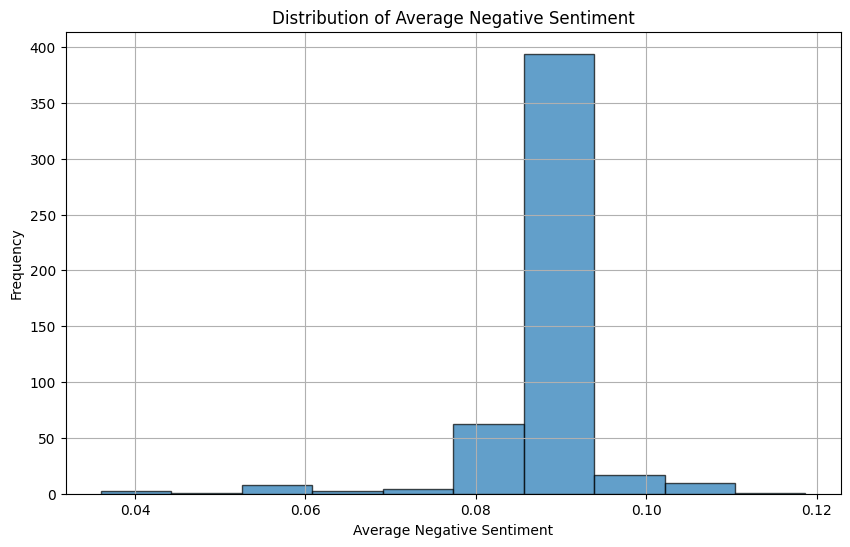

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
# Dropping NaN values
cleaned_data = data['Average Negative Sentiment'].dropna()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data, bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Negative Sentiment')
plt.xlabel('Average Negative Sentiment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [52]:

# Function to normalize and invert 'Average Negative Sentiment'
def normalize_and_invert_sentiment(df, column):
    # Ignore NaN values for normalization
    valid_values = df[column].dropna()

    # Normalize the values to a 0-5 scale
    min_val = valid_values.min()
    max_val = valid_values.max()
    normalized = 5 * (valid_values - min_val) / (max_val - min_val)

    # Invert the values
    inverted = 5 - normalized

    # Assign the inverted values back to the DataFrame
    df.loc[valid_values.index, 'Sentiment Star Rating'] = inverted

    # Replace NaN values with "no data"
    df['Sentiment Star Rating'].fillna("no data", inplace=True)

# Assuming your DataFrame is named 'data'
normalize_and_invert_sentiment(data, 'Average Negative Sentiment')

# Display the DataFrame to verify the changes
display(data[['Product Name', 'Average Negative Sentiment', 'Sentiment Star Rating']])


<ipython-input-52-7e6f628d3231>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[valid_values.index, 'Sentiment Star Rating'] = inverted


,Product Name,Average Negative Sentiment,Sentiment Star Rating
0,1st Financial Bank USA credit card,0.046333,4.375
1,Signature Cashback Rewards Credit Card,NaN,no data
2,Platinum+ Mastercard,0.087349,1.894201
3,Ally Platinum Mastercard_1,0.087349,1.894201
4,Ally Platinum Mastercard_2,0.087349,1.894201
...,...,...,...
643,Visa Cash Rewards,NaN,no data
644,Platinum Visa,NaN,no data
645,Visa Unicorn Credit Card,0.054750,3.865927
646,Visa Credit Card Platinum,NaN,no data


# Filtering tool code begins here!#

In [58]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Assuming 'data' is already defined as your DataFrame

# Global variable to store the filtered DataFrame
filtered_data = data.copy()

# Dropdown widget for credit tiers
credit_tier_dropdown = widgets.Dropdown(
    options=[
        'No credit score',
        'Credit score 619 or less',
        'Credit scores from 620 to 719',
        'Credit score of 720 or greater'
    ],
    value='No credit score',  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of all state abbreviations
states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA',
    'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
    'VA', 'WA', 'WV', 'WI', 'WY'
]

# Dropdown widget for available states
states_dropdown = widgets.Dropdown(
    options=states,
    value='AL',  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of possible card features
card_features = [
    'Chip card',
    'Contactless Payments',
    'Fee-free foreign transactions',
    'Mobile wallet provisioning (for example, Apple Pay)',
    'Other_features',
    'No_features'
]

# SelectMultiple widget for card features
features_dropdown = widgets.SelectMultiple(
    options=card_features,
    value=[],  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of possible services
services = [
    'Access to Free Credit Scores',
    'Automobile rental insurance',
    'Credit card registration',
    'Debt cancellation coverage',
    'Discounts on purchases of goods and services (non travel related)',
    'Extension on manufacturer’s warranty',
    'Other_services',
    'No_Services'
]

# SelectMultiple widget for services
services_dropdown = widgets.SelectMultiple(
    options=services,
    value=[],  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# List of possible rewards
rewards = [
    'Cashback rewards',
    'Other rewards',
    'Travel-related rewards',
    'No_rewards'
]

# SelectMultiple widget for rewards
rewards_dropdown = widgets.SelectMultiple(
    options=rewards,
    value=[],  # Default value
    description='',  # Remove the description
    disabled=False,
    layout={'width': 'max-content'}
)

# Output widget to display the filtered dataframe
output_filtered_data = widgets.Output()

# Label widget to display the number of rows in the filtered dataset
row_count_label = widgets.Label(value="Number of rows in the filtered dataset: 0")

# Global variable to store the final filtered dataset
final_filtered_data = pd.DataFrame()

# Function to filter the dataframe based on credit tier selection
def filter_by_credit_tier(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_tier = credit_tier_dropdown.value
            filtered_data = data[data[selected_tier] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected state
def filter_by_state(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_state = states_dropdown.value
            filtered_data = filtered_data[filtered_data['Available States'].apply(lambda x: selected_state in x)]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected features
def filter_by_features(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_features = features_dropdown.value
            for feature in selected_features:
                filtered_data = filtered_data[filtered_data[feature] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected services
def filter_by_services(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_services = services_dropdown.value
            for service in selected_services:
                filtered_data = filtered_data[filtered_data[service] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of rows in the filtered dataset: {len(filtered_data)}"

# Function to filter the dataframe based on selected rewards
def filter_by_rewards(change):
    global filtered_data, final_filtered_data
    if change['type'] == 'change' and change['name'] == 'value':
        with output_filtered_data:
            clear_output(wait=True)  # Clear the previous output
            selected_rewards = rewards_dropdown.value
            for reward in selected_rewards:
                filtered_data = filtered_data[filtered_data[reward] == 1]
            # Update the final filtered data
            final_filtered_data = filtered_data.copy()
            # Display the filtered DataFrame
            display(filtered_data.head())
            # Update the row count label
            row_count_label.value = f"Number of cards in the filtered dataset: {len(filtered_data)}"

# Watch for changes in the dropdown menus
credit_tier_dropdown.observe(filter_by_credit_tier, names='value')
states_dropdown.observe(filter_by_state, names='value')
features_dropdown.observe(filter_by_features, names='value')
services_dropdown.observe(filter_by_services, names='value')
rewards_dropdown.observe(filter_by_rewards, names='value')

# Arrange the dropdowns in a vertical box with labels properly displayed
ui = widgets.VBox([
    widgets.HBox([widgets.Label("Your Credit Tier:", layout={'width': '200px'}), credit_tier_dropdown]),
    widgets.HBox([widgets.Label("Your State:", layout={'width': '200px'}), states_dropdown]),
    widgets.HBox([widgets.Label("Card Features Requested:", layout={'width': '200px'}), features_dropdown]),
    widgets.HBox([widgets.Label("Card Services Requested:", layout={'width': '200px'}), services_dropdown]),
    widgets.HBox([widgets.Label("Card Rewards Requested:", layout={'width': '200px'}), rewards_dropdown]),
    row_count_label,
    output_filtered_data
])

# Display the UI
display(ui)


.
























.

.



.

.


.

.


.

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# Output widget to display the graphs
output_graphs = widgets.Output()

# Function to create histograms for various APR values based on credit tier selection
def plot_apr_distributions(change):
    selected_tier = credit_tier_dropdown.value

    with output_graphs:
        clear_output(wait=True)  # Clear the previous output

        # Check if there is any data to plot
        if len(final_filtered_data) == 0:
            print("No data to display")
            return

        # Define APR columns based on credit tier selection
        if selected_tier in ['No credit score', 'Credit score 619 or less']:
            apr_columns = [
                ('Purchase APR min', 'Advance APR min')
            ]
        elif selected_tier == 'Credit scores from 620 to 719':
            apr_columns = [
                ('Purchase APR median', 'Advance APR median')
            ]
        elif selected_tier == 'Credit score of 720 or greater':
            apr_columns = [
                ('Purchase APR max', 'Advance APR max')
            ]
        else:
            print("Invalid selection")
            return

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        for i, (col_purchase, col_advance) in enumerate(apr_columns):
            # Determine common x-axis limits for Purchase APR
            x_min_purchase = final_filtered_data[col_purchase].min()
            x_max_purchase = final_filtered_data[col_purchase].max()

            # Plot for Purchase APR
            sns.histplot(final_filtered_data[col_purchase], bins=30, ax=axs[0], kde=True, palette='viridis' )
            axs[0].set_title(f'Distribution of {col_purchase}')
            axs[0].set_xlabel('APR')
            axs[0].set_ylabel('Frequency')
            axs[0].set_xlim(x_min_purchase, x_max_purchase)

            # Determine common x-axis limits for Advance APR
            x_min_advance = final_filtered_data[col_advance].min()
            x_max_advance = final_filtered_data[col_advance].max()

            # Plot for Advance APR
            sns.histplot(final_filtered_data[col_advance], bins=30, ax=axs[1], kde=True, palette='BuPu')
            axs[1].set_title(f'Distribution of {col_advance}')
            axs[1].set_xlabel('APR')
            axs[1].set_ylabel('Frequency')
            axs[1].set_xlim(x_min_advance, x_max_advance)

        plt.tight_layout()
        plt.show()

# Display the plot button
plot_button = widgets.Button(description="Plot APR Distributions", disabled=False, button_style='', tooltip='Click to plot APR distributions', icon='bar-chart')

# Function to call the plot function on button click
def on_plot_button_click(b):
    plot_apr_distributions(None)

plot_button.on_click(on_plot_button_click)

# Display the plot button and output widget for graphs
display(plot_button, output_graphs)

# Watch for changes in the credit tier dropdown menu
credit_tier_dropdown.observe(plot_apr_distributions, names='value')


Button(description='Plot APR Distributions', icon='bar-chart', style=ButtonStyle(), tooltip='Click to plot APR…

Output()

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to create subplots for Cumulative Yearly Fee, Balance Transfer Fee ($), and Balance Transfer Fee (%)
def plot_fee_distributions():
    with output_filtered_data:
        clear_output(wait=True)  # Clear the previous output

        # Exclude cards with a Cumulative Yearly Fee of 0
        yearly_fee_data = final_filtered_data[final_filtered_data['Cumulative Yearly Fee'] > 0]

        # Define the bins for Cumulative Yearly Fee
        bins = list(range(0, 100, 20)) + [100, 500]
        labels = ['1-20', '21-40', '41-60', '61-80', '81-100', '101-500']
        yearly_fee_data['Fee Bin'] = pd.cut(yearly_fee_data['Cumulative Yearly Fee'], bins=bins, labels=labels, right=False)

        # Exclude cards with a Balance Transfer Fee of 0$
        transfer_fee_dollar_data = final_filtered_data[final_filtered_data['Balance Transfer Fee ($)'] > 0]

        # Exclude cards with a Balance Transfer Fee of 0%
        transfer_fee_percentage_data = final_filtered_data[final_filtered_data['Balance Transfer Fee (%)'] > 0]

        # Create subplots
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Plot for Cumulative Yearly Fee
        sns.countplot(data=yearly_fee_data, x='Fee Bin', palette='viridis', ax=axs[0])
        axs[0].set_title('Distribution of Cumulative Yearly Fee')
        axs[0].set_xlabel('Cumulative Yearly Fee Bins')
        axs[0].set_ylabel('Number of Cards')
        zero_fee_count = final_filtered_data['Cumulative Yearly Fee'].value_counts().get(0.0, 0)
        axs[0].annotate(f"{round(zero_fee_count/len(final_filtered_data)*100, 2)}% cards have no yearly fee.", xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

        # Plot for Balance Transfer Fee ($)
        sns.countplot(data=transfer_fee_dollar_data, x='Balance Transfer Fee ($)', order=sorted(transfer_fee_dollar_data['Balance Transfer Fee ($)'].unique()), palette='viridis', ax=axs[1])
        axs[1].set_title('Distribution of Balance Transfer Fee ($)')
        axs[1].set_xlabel('Balance Transfer Fee ($)')
        axs[1].set_ylabel('Number of Cards')
        zero_fee_dollar_count = final_filtered_data['Balance Transfer Fee ($)'].value_counts().get(0.0, 0)
        axs[1].annotate(f"{round(zero_fee_dollar_count/len(final_filtered_data)*100,2)}% cards have a $0 balance transfer fee.", xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

        # Plot for Balance Transfer Fee (%)
        sns.countplot(data=transfer_fee_percentage_data, x='Balance Transfer Fee (%)', order=sorted(transfer_fee_percentage_data['Balance Transfer Fee (%)'].unique()), palette='viridis', ax=axs[2])
        axs[2].set_title('Distribution of Balance Transfer Fee (%)')
        axs[2].set_xlabel('Balance Transfer Fee (%)')
        axs[2].set_ylabel('Number of Cards')
        zero_fee_percentage_count = final_filtered_data['Balance Transfer Fee (%)'].value_counts().get(0.00, 0)
        axs[2].annotate(f"{round(zero_fee_percentage_count/len(final_filtered_data)*100, 2)}% cards have a 0% balance transfer fee.", xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

        plt.tight_layout()
        plt.show()

# Display the plot button
plot_button = widgets.Button(description="Plot Fee Distributions", disabled=False, button_style='', tooltip='Click to plot fee distributions', icon='bar-chart')

# Function to call the plot function on button click
def on_plot_button_click(b):
    plot_fee_distributions()

plot_button.on_click(on_plot_button_click)

# Display the plot button
display(plot_button, output_filtered_data)

Button(description='Plot Fee Distributions', icon='bar-chart', style=ButtonStyle(), tooltip='Click to plot fee…

Output()

In [61]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Dropdown widget for sorting options
sorting_dropdown1 = widgets.Dropdown(
    options=['None'] + [
        'Advance APR median',
        'Purchase APR median',
        'Intro APR median',
        'Cumulative Yearly Fee'
    ],
    value='None',  # Default value
    description='',
    disabled=False,
    layout={'width': '200px'}  # Adjust the width of the dropdown itself
)

# Custom label for the dropdown
sorting_label = widgets.Label("Sort by (low -> high):")

# Output widget to display the sorted dataframe
output_top = widgets.Output()

# Global variable to store the sorted DataFrame
sorted_data = pd.DataFrame()

# Function to sort the dataframe based on the selected metric
def sort_dataframe(change):
    global final_filtered_data, sorted_data
    selected_metric1 = sorting_dropdown1.value
    with output_top:
        clear_output(wait=True)  # Clear the previous output
        if selected_metric1 != 'None':
            sorted_data = final_filtered_data.sort_values(by=selected_metric1)
        else:
            sorted_data = final_filtered_data.copy()

        # Replace final_filtered_data with the sorted dataframe
        final_filtered_data = sorted_data.copy()

        display(final_filtered_data[['Institution Name', 'Product Name', 'Advance APR median', 'Purchase APR median', 'Intro APR median',
                                     'Cumulative Yearly Fee', 'Other Periodic Fees Cumulative', 'Fee Explanation',
                                     'Balance Transfer Fees Cumulative', 'Cash Advance Fees Cumulative',
                                     'Foreign Transaction Fees Cumulative', 'Late Fee Cumulative',
                                     'Over Limit Fee Cumulative', 'Website for Consumer']])

# Watch for changes in the dropdown menu
sorting_dropdown1.observe(sort_dataframe, names='value')

# Display the dropdown menu and output widget
display(widgets.HBox([sorting_label, sorting_dropdown1]), output_top)


Output()

.



.


.


.

.


.

.



.

.


.


.




.

.




.

In [62]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd

# Function to convert numeric score to star symbols
def convert_to_stars(score):
    if isinstance(score, (int, float)):
        full_stars = int(score)
        half_star = (score - full_stars) >= 0.5
        stars = '★' * full_stars + ('½' if half_star else '')
        return stars
    return "no data"

# Function to display detailed information about the top card
def display_top_card_info():
    with output_top:
        clear_output(wait=True)
        if len(final_filtered_data) == 0:
            print("No data available")
            return

        top_card = final_filtered_data.iloc[0]

        def get_value(column):
            return top_card[column] if pd.notna(top_card[column]) else "no data"

        sentiment_stars = convert_to_stars(top_card['Sentiment Star Rating'])

        display(HTML(f"""
        <h1>{get_value('Institution Name')}</h1>
        <h2>{get_value('Product Name')}</h2>
        <p><b>Advance APR median:</b> {get_value('Advance APR median')}</p>
        <ul><li>The median annual percentage rate (APR) charged on cash advances taken with a credit card, indicating the typical interest rate applied to these transactions.</li></ul>
        <p><b>Purchase APR median:</b> {get_value('Purchase APR median')}</p>
        <ul><li>The median annual percentage rate (APR) applied to purchases made with a credit card, representing the standard interest rate most cardholders experience for their purchases.</li></ul>
        <p><b>Intro APR median:</b> {get_value('Intro APR median')}</p>
        <ul><li>The median introductory annual percentage rate (APR) offered to new credit cardholders for a limited time, often lower than the regular APR to attract new customers.</li></ul>
        <hr>
        <p><b>Cumulative Yearly Fee:</b> {get_value('Cumulative Yearly Fee')}</p>
        <ul><li>The total annual fee charged by a credit card issuer, which may include membership fees or other recurring charges applicable over the course of a year.</li></ul>
        <p><b>Other Periodic Fees Cumulative:</b> {get_value('Other Periodic Fees Cumulative')}</p>
        <ul><li>The total amount of various recurring fees other than the annual fee, such as monthly service charges or account maintenance fees, accumulated over a specified period.</li></ul>
        <p><b>Fee Explanation:</b> {get_value('Fee Explanation')}</p>
        <hr>
        <p><b>Balance Transfer Fees Cumulative:</b> {get_value('Balance Transfer Fees Cumulative')}</p>
        <ul><li>The total fees incurred when transferring a balance from one credit card to another, accumulated over a certain period.</li></ul>
        <p><b>Cash Advance Fees Cumulative:</b> {get_value('Cash Advance Fees Cumulative')}</p>
        <ul><li>The total fees charged for taking cash advances using a credit card, accumulated over a specific timeframe.</li></ul>
        <p><b>Foreign Transaction Fees Cumulative:</b> {get_value('Foreign Transaction Fees Cumulative')}</p>
        <ul><li>The total fees charged for making purchases in foreign currencies or with foreign merchants, accumulated over a certain period.</li></ul>
        <p><b>Late Fee Cumulative:</b> {get_value('Late Fee Cumulative')}</p>
        <ul><li>The total fees charged for making late payments on a credit card, accumulated over a specified timeframe.</li></ul>
        <p><b>Over Limit Fee Cumulative:</b> {get_value('Over Limit Fee Cumulative')}</p>
        <ul><li>The total fees charged for exceeding the credit limit on a credit card, accumulated over a certain period.</li></ul>
        <hr>
        <p><b>Sentiment Star Rating:</b> {sentiment_stars}</p>
        <ul><li>This 0-5 star rating reflects the average customer sentiment towards this card provided based on current customer complaints submitted to the CFPB.</li></ul>
        <p><b>Issue Summary:</b> {get_value('Issue Summary')}</p>
        <ul><li>These phrases indicate the most common issues customers raised to the CFPB about the card in question</li></ul>
        <hr>
        <p><b>Website for Consumer:</b> <a href="{get_value('Website for Consumer')}" target="_blank">{get_value('Website for Consumer')}</a></p>
        """))

# Output widget to display the card information
output_top = widgets.Output()

# Display the button to show the top card information
top_card_button = widgets.Button(
    description="Show Top Card Info",
    disabled=False,
    button_style='',
    tooltip='Click to display top card information',
    icon='info',
    layout=widgets.Layout(width='250px')  # Adjust the width as needed
)

# Function to call the display function on button click
def on_top_card_button_click(b):
    display_top_card_info()

top_card_button.on_click(on_top_card_button_click)

# Display the button and output widget
display(top_card_button, output_top)


Button(description='Show Top Card Info', icon='info', layout=Layout(width='250px'), style=ButtonStyle(), toolt…

Output()

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.
